In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/naomiverkerk/TM10007.git


In [2]:
## Import
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import svm
from sklearn import decomposition
import statistics

# Preprocessing
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder

# Classifiers and kernels
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer, make_column_selector as selector


In [3]:
# ## Import
# from sklearn import model_selection
# from sklearn import metrics
# from sklearn import feature_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import svm
# from sklearn import decomposition


# from load_data import load_data
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Classifiers and kernels
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report



In [4]:
##Loading Data
data = load_data() 
X = data
X = X.replace(np.inf, np.nan)
Y = data['label']
del X['label']

# Duplicate check

In [5]:
# Check for duplicates values
data.drop_duplicates(keep='first')
print(f'Number of duplicated datasets = {data.duplicated().sum()}')

# Check for duplicates columns
data.columns.drop_duplicates(keep='first')
print(f'Number of duplicated features = {data.columns.duplicated().sum()}')

Number of duplicated datasets = 0
Number of duplicated features = 0


# Label counter

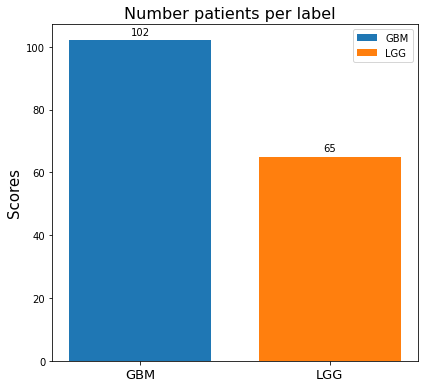

In [6]:
label_count = Y.value_counts()
z = np.arange(len(label_count.index))
width = 0.75
fig, ax = plt.subplots(figsize = (6,5.5))
count1 = ax.bar(0.5, label_count.values[0], width, label=label_count.index[0])
count2 = ax.bar(1.5, label_count.values[1], width, label=label_count.index[1])

ax.set_ylabel('Scores', fontsize = 15)
ax.set_title('Number patients per label  ', fontsize = 16)
ax.set_xticks([0.5,1.5], list(label_count.index), fontsize = 13)
ax.legend()
ax.bar_label(count1, padding=3)
ax.bar_label(count2, padding=3)
ax.grid(False)
fig.tight_layout()

plt.show()

In [7]:
## Split
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 4, stratify = Y)

In [8]:
## Nog ff naar kijken of het werkt
# from fitter import Fitter, get_common_distributions, get_distributions
# fi = []

# col = X.columns
# for i in (range(0,X.shape[1],1)):
#     try:
#         X_tr = X[col[i]].values
#         f = Fitter(X_tr,
#             distributions=['gamma',
#                             'lognorm',
#                             "beta",
#                             "burr",
#                             "norm"])
#         f.fit()
#         fi.append(list(pd.DataFrame(f.get_best(method = 'sumsquare_error')).columns))
#     except Exception:
#         pass

# flat_list = [item for sublist in fi for item in sublist]
# from collections import Counter
# Counter(flat_list).most_common()       
# from sklearn import preprocessing
# import seaborn as sns
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt

# le = preprocessing.LabelEncoder()

# y_10 = le.fit_transform(Y)
# Y_train_10 = le.fit_transform(Y_train)
# Y_test_10 = le.fit_transform(Y_test)
# # classes = data.label
# # classes = list(classes.unique())
# colour = sns.color_palette("Set2")
# color1=colour[0]
# color2=colour[1]

# colormap = np.array([color1,color2])

# fig = plt.figure(figsize=(24,8))
# ax = fig.add_subplot(131)
# ax.set_title(f"Brats, entire dataset = {len(data)}", fontsize=15)
# ax.scatter(data.iloc[:,0], data.iloc[:,1], marker='o', c=colormap[y_10],
#            s=45, edgecolor='k', cmap=plt.cm.Paired)

# ax = fig.add_subplot(132)
# ax.set_title(f"Training data = {len(X_train)}", fontsize=15)
# ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], marker='o', c=colormap[Y_train_10],
#            s=45, edgecolor='k', cmap=plt.cm.Paired)

# ax = fig.add_subplot(133)
# ax.set_title(f"Test data= {len(X_test)}", fontsize=15)
# ax.scatter(X_test.iloc[:,0], X_test.iloc[:,1], marker='o', c=colormap[Y_test_10],
#            s=45, edgecolor='k', cmap=plt.cm.Paired)   

# GBM_patch = mpatches.Patch(color=colour[0], label='GBM')
# LGG_patch = mpatches.Patch(color=colour[1], label='LGG')
# fig.legend(handles=[GBM_patch, LGG_patch],loc="center right", prop={'size': 12})
# fig.subplots_adjust(right=0.95)

# plt.show()          

In [9]:
## Features weghalen met teveel missing values
acceptabele_ratio = 0.5
train_size = len(X_train.index)
removal_rate = round(train_size*acceptabele_ratio)

X_train = X_train.dropna(axis=1, thresh=removal_rate)
common_cols = list(set(X_train.columns).intersection(X_test.columns))
X_test = X_test[common_cols]

In [10]:
imputer = KNNImputer()
imputer.fit(X_train)
X_train_imputer = imputer.transform(X_train)
X_test_imputer = imputer.transform(X_test)

# np.isnan(X_train_imputer).sum()
# np.isnan(X_test_imputer).sum()

C:\Users\Sara\miniconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [11]:
# ## Imputation met median
# X_train_missing_median = X_train.fillna(X_train.median())
# X_train_missing_median = np.nan_to_num(X_train_missing_median)
# X_test_missing_median = X_test.fillna(X_test.median())
# X_test_missing_median = np.nan_to_num(X_test_missing_median)

In [12]:
## Scaling
scaler = RobustScaler()
scaler.fit(X_train_imputer)
X_train_scaled = scaler.transform(X_train_imputer)
X_test_scaled = scaler.transform(X_test_imputer)

# X_train_scaled = scaler.transform(X_train_missing_median)
# X_train_scaled = np.nan_to_num(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_missing_median)
# X_test_scaled = np.nan_to_num(X_test_scaled)

In [13]:
## scaling van y
scaler = LabelEncoder()
scaler.fit(Y_train)
Y_train_final = scaler.transform(Y_train)
Y_test_final = scaler.transform(Y_test)

In [14]:
## PCA
pca = decomposition.PCA(n_components=0.99, svd_solver= 'full')
pca.fit(X_train_scaled)
X_train_final = pca.transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)
# explained_variance = np.cumsum(pca.explained_variance_ratio_)


In [26]:
print(f'nan in x train final {np.isnan(X_train_final).sum()}, nan in x train final{np.isnan(X_test_final).sum()}')



nan in x train final 0, nan in x train final0


## Random Forest

In [15]:
cv_10fold = StratifiedKFold(n_splits=5)
cv_5fold = StratifiedKFold(n_splits=5)

In [16]:

# results = []
# best_min_samples_split = []

# for validation_index, train_index in cv_10fold.split(X_train_final, Y_train_final):

#         # Split the data properly
#         X_validation_CV = X_train_final[validation_index]
#         Y_validation_CV = Y_train_final[validation_index]
        
#         X_train_CV = X_train_final[train_index]
#         Y_train_CV = Y_train_final[train_index]

#         parameters = {
#                         "criterion": ['gini', 'entropy'],
#                         "min_samples_split": list(range(2,40,2)),
#                         # "min_impurity_decrease": [0,1,2,3,4,5],
#                         "max_features": [1,2,3,4,5],
#                         "min_samples_leaf": list(range(1,20,2)),
#         }
#         clf = RandomForestClassifier()
#         cv_5fold = StratifiedKFold(n_splits=5)
#         grid_search = GridSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc')
#         grid_search.fit(X_validation_CV, Y_validation_CV)
        
#         # Get resulting classifier
#         clf = grid_search.best_estimator_
#         print(f'Best classifier for criterion={clf.criterion} & min_samples_split={clf.min_samples_split} & max_features={clf.max_features} & min_samples_leaf={clf.min_samples_leaf}')

#         probabilities = clf.predict_proba(X_test)
#         scores = probabilities[:, 1]
        
#         auc = metrics.roc_auc_score(Y_train_CV, scores)
#         results.append({
#             'auc': auc,
#             'criterion': clf.criterion,
#             'min_samples_split': clf.min_samples_split,
#             'max_features': clf.max_features,
#             "min_samples_leaf": clf.min_samples_leaf,
#             'set': 'test'
#         })
        
#         probabilities_validation = clf.predict_proba(X_validation_CV)
#         scores_validation = probabilities_validation[:, 1]

#         # Get the auc
#         auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
#         results.append({
#             'auc': auc_validation,
#             'criterion': clf.criterion,
#             'min_samples_split': clf.min_samples_split,
#             'max_features': clf.max_features,
#             "min_samples_leaf": clf.min_samples_leaf,
#             'set': 'validation'
#         })

#     # plt.figure(dpi=250)
#     # plot_tree(clf, filled=True,
#     #             class_names=class_names,
#     #             feature_names=feature_names,
#     #             );



# results = pd.DataFrame(results)
# sns.boxplot(y='auc', x='set', data=results)

# p = list(parameters.keys())
# optimal_parameter = []
# # print(f"The optimal N={optimal_n}")

# parameter_keys = list(parameters.keys())
# for item in parameter_keys:
#     best_item = [] 
#     for i in list(range(0,10,2)):
#         best_item.append(results[item][i])

#     optimal_parameter.append(statistics.median(best_item))
#     print(f"The optimal {item}={optimal_parameter[-1]}")
  



In [17]:



    #     # Split the data properly
    #     X_validation = X_train_final[validation_index]
    #     y_validation = Y_train_final[validation_index]
        
    #     X_test = X_train_final[test_index]
    #     y_test = Y_train_final[test_index]

    #     parameters = {
    #                     "criterion": ['gini', 'entropy'],
    #                     "min_samples_split": list(range(2,40,2)),
    #                     # "min_impurity_decrease": [0,1,2,3,4,5],
    #                     "max_features": [1,2,3,4,5],
    #                     "min_samples_leaf": list(range(1,20,2)),
    #     }
    #     clf = RandomForestClassifier()
    #     cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    #     grid_search = model_selection.GridSearchCV(clf, parameters, cv=cv_10fold, scoring='roc_auc')
    #     grid_search.fit(X_validation, y_validation)
        
    #     # Get resulting classifier
    #     clf = grid_search.best_estimator_
    #     print(f'Best classifier for criterion={clf.criterion} & min_samples_split={clf.min_samples_split} & max_features={clf.max_features} & min_samples_leaf={clf.min_samples_leaf}')

    #     probabilities = clf.predict_proba(X_test)
    #     scores = probabilities[:, 1]
        
    #     auc = metrics.roc_auc_score(y_test, scores)
    #     results.append({
    #         'auc': auc,
    #         'criterion': clf.criterion,
    #         'min_samples_split': clf.min_samples_split,
    #         'max_features': clf.max_features,
    #         "min_samples_leaf": clf.min_samples_leaf,
    #         'set': 'test'
    #     })
        
    #     probabilities_validation = clf.predict_proba(X_validation)
    #     scores_validation = probabilities_validation[:, 1]

    #     # Get the auc
    #     auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    #     results.append({
    #         'auc': auc_validation,
    #         'criterion': clf.criterion,
    #         'min_samples_split': clf.min_samples_split,
    #         'max_features': clf.max_features,
    #         "min_samples_leaf": clf.min_samples_leaf,
    #         'set': 'validation'
    #     })

    # # plt.figure(dpi=250)
    # # plot_tree(clf, filled=True,
    # #             class_names=class_names,
    # #             feature_names=feature_names,
    # #             );



    # results = pd.DataFrame(results)
    # sns.boxplot(y='auc', x='set', data=results)

    # p = list(parameters.keys())
    # optimal_parameter = []
    # # print(f"The optimal N={optimal_n}")

    # parameter_keys = list(parameters.keys())
    # for item in parameter_keys:
    #     best_item = [] 
    #     for i in list(range(0,10,2)):
    #         best_item.append(results[item][i])

    #     optimal_parameter.append(statistics.median(best_item))
    #     print(f"The optimal {item}={optimal_parameter[-1]}")
  
   

## Decision tree

In [18]:
# cv_10fold = StratifiedKFold(n_splits=10)
# results = []
# best_min_samples_split = []

# for validation_index, train_index in cv_10fold.split(X_train_final, Y_train_final):

#         # Split the data properly
#         X_validation_CV = X_train_final[validation_index]
#         Y_validation_CV = Y_train_final[validation_index]
        
#         X_train_CV = X_train_final[train_index]
#         Y_train_CV = Y_train_final[train_index]

#         parameters = {
#                         "criterion": ['gini', 'entropy'],
#                         "min_samples_split": list(range(2,40,2)),
#                         # "min_impurity_decrease": [0,1,2,3,4,5],
#                         "max_features": [1,2,3,4,5],
#                         "min_samples_leaf": list(range(1,20,2)),
#         }
#         clf = RandomForestClassifier()
#         cv_5fold = StratifiedKFold(n_splits=5)
#         grid_search = GridSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc')
#         grid_search.fit(X_validation_CV, Y_validation_CV)
        
#         # Get resulting classifier
#         clf = grid_search.best_estimator_
#         print(f'Best classifier for criterion={clf.criterion} & min_samples_split={clf.min_samples_split} & max_features={clf.max_features} & min_samples_leaf={clf.min_samples_leaf}')

#         probabilities = clf.predict_proba(X_test)
#         scores = probabilities[:, 1]
        
#         auc = metrics.roc_auc_score(Y_train_CV, scores)
#         results.append({
#             'auc': auc,
#             'criterion': clf.criterion,
#             'min_samples_split': clf.min_samples_split,
#             'max_features': clf.max_features,
#             "min_samples_leaf": clf.min_samples_leaf,
#             'set': 'test'
#         })
        
#         probabilities_validation = clf.predict_proba(X_validation_CV)
#         scores_validation = probabilities_validation[:, 1]

#         # Get the auc
#         auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
#         results.append({
#             'auc': auc_validation,
#             'criterion': clf.criterion,
#             'min_samples_split': clf.min_samples_split,
#             'max_features': clf.max_features,
#             "min_samples_leaf": clf.min_samples_leaf,
#             'set': 'validation'
#         })

#     # plt.figure(dpi=250)
#     # plot_tree(clf, filled=True,
#     #             class_names=class_names,
#     #             feature_names=feature_names,
#     #             );



# results = pd.DataFrame(results)
# sns.boxplot(y='auc', x='set', data=results)

# p = list(parameters.keys())
# optimal_parameter = []
# # print(f"The optimal N={optimal_n}")

# parameter_keys = list(parameters.keys())
# for item in parameter_keys:
#     best_item = [] 
#     for i in list(range(0,10,2)):
#         best_item.append(results[item][i])

#     optimal_parameter.append(statistics.median(best_item))
#     print(f"The optimal {item}={optimal_parameter[-1]}")
  



## K-nearest neighbour

In [19]:
results = []
best_n_neighbors = []
n_components = []


for validation_index, train_index in cv_10fold.split(X_train_final, Y_train_final):
    # Split the data properly
    X_validation_CV = X_train_final[validation_index]
    Y_validation_CV = Y_train[validation_index]

    X_train_CV = X_train_final[train_index]
    Y_train_CV = Y_train[train_index]

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {
                    "n_neighbors": list(range(1, 26, 2)),
                    "weights": ["uniform", "distance"],
                    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]

    }
    
    clf = KNeighborsClassifier()
    grid_search = GridSearchCV(clf, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation_CV, Y_validation_CV)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_train_CV, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        "weights": clf.weights,
        "metric": clf.metric,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation_CV)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        "weights": clf.weights,
        "metric": clf.metric,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_parameter = []
parameter_keys = list(parameters.keys())

for item in parameter_keys:
    best_item = [] 
    for i in list(range(0,10,2)):
        best_item.append(results[item][i])
    
    optimal_parameter.append(statistics.median(best_item))
    print(f"The optimal {item}={optimal_parameter[-1]}")

results

C:\Users\Sara\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Logistic regression

In [ ]:
# import warnings
# from sklearn.linear_model import LogisticRegression
# import seaborn as sns
# import statistics

# results = []
# best_n_neighbors = []
# n_components = []


# # Loop over the folds
# for validation_index, test_index in cv_10fold.split(X_train_final, Y_train_final):
#     # Split the data properly
#     X_validation = X_train_final[validation_index]
#     y_validation = Y_train_final[validation_index]

#     X_test = X_train_final[test_index]
#     y_test = Y_train_final[test_index]

#     parameters = {
#                     "solver": ['newton-cg', 'lbfgs', 'liblinear'],
#                     "C": [100, 10, 1.0, 0.1, 0.01],
#     }

#     lg = LogisticRegression()
#     cv_10fold = model_selection.StratifiedKFold(n_splits=5)
#     grid_search = model_selection.GridSearchCV(lg, parameters, cv=cv_10fold, scoring='roc_auc')
#     grid_search.fit(X_validation, y_validation)

#     clf = grid_search.best_estimator_

#     # Test the classifier on the test data
#     probabilities = clf.predict_proba(X_test)
#     scores = probabilities[:, 1]
    
#     # Get the auc
#     auc = metrics.roc_auc_score(y_test, scores)
#     results.append({
#         'auc': auc,
#         "solver": clf.solver,
#         "C": clf.C,
#         'set': 'test'
#     })
    
#     # Test the classifier on the validation data
#     probabilities_validation = clf.predict_proba(X_validation)
#     scores_validation = probabilities_validation[:, 1]
    
#     # Get the auc
#     auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
#     results.append({
#         'auc': auc,
#         "solver": clf.solver,
#         "C": clf.C,
#         'set': 'validation'
#     })
    
# # Create results dataframe and plot it
# results = pd.DataFrame(results)
# sns.boxplot(y='auc', x='set', data=results)

# optimal_parameter = []
# parameter_keys = list(parameters.keys())

# for item in parameter_keys:
#     best_item = [] 
#     for i in list(range(0,10,2)):
#         best_item.append(results[item][i])
    
#     optimal_parameter.append(statistics.median(best_item))
#     print(f"The optimal {item}={optimal_parameter[-1]}")

# results


## Naives Bayes

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# # # model = MultinomialNB().fit(X_train, y_train)

# best_var_smoothing = []
# results = []

# cv_20fold = model_selection.StratifiedKFold(n_splits=5)

# # Loop over the folds
# for validation_index, test_index in cv_20fold.split(X_train_final, Y_train_final):

#     # Split the data properly
#     X_validation = X_train_final[validation_index]
#     y_validation = Y_train_final[validation_index]
    
#     X_test = X_train_final[test_index]
#     y_test = Y_train_final[test_index]

#     parameters = {"var_smoothing": list(np.logspace(0,-9, num=101))}
#     gnb = GaussianNB()
#     cv_10fold = model_selection.StratifiedKFold(n_splits=5)
#     grid_search = model_selection.GridSearchCV(gnb, parameters, cv=cv_10fold, scoring='roc_auc')
#     grid_search.fit(X_validation, y_validation)
    
#     # Get resulting classifier
#     clf = grid_search.best_estimator_
#     print(f'Best classifier for parameter={clf.var_smoothing}')
#     best_var_smoothing.append(clf.var_smoothing)
    
#     # Test the classifier on the test data
#     probabilities = clf.predict_proba(X_test)
#     scores = probabilities[:, 1]
    
#     # Get the auc
#     auc = metrics.roc_auc_score(y_test, scores)
#     results.append({
#         'auc': auc,
#         'k': clf.var_smoothing,
#         'set': 'test'
#     })
    
#     # Test the classifier on the validation data
#     probabilities_validation = clf.predict_proba(X_validation)
#     scores_validation = probabilities_validation[:, 1]
    
#     # Get the auc
#     auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
#     results.append({
#         'auc': auc_validation,
#         'k': clf.var_smoothing,
#         'set': 'validation'
#     })
    
# # Create results dataframe and plot it
# results = pd.DataFrame(results)
# sns.boxplot(y='auc', x='set', data=results)

# optimal_var_smoothing = (np.median(best_var_smoothing))
# print(f"The optimal value of parameter={optimal_var_smoothing}")



## SVM

## Neural Network

In [ ]:
# from sklearn.neural_network import MLPClassifier
# import warnings
# import seaborn as sns
# import statistics
# # Create a 20 fold stratified CV iterator

# cv_20fold = model_selection.StratifiedKFold(n_splits=5)
# results = []
# best_n_neighbors = []
# n_components = []

# # Loop over the folds
# for validation_index, test_index in cv_20fold.split(X_train_final, Y_train_final):
#     # Split the data properly
#     X_validation = X_train_final[validation_index]
#     y_validation = Y_train_final[validation_index]

#     X_test = X_train_final[test_index]
#     y_test = Y_train_final[test_index]

#     parameters = {
#                     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#                     'activation': ['tanh', 'relu'],
#                     'solver': ['sgd', 'adam'],
#                     'alpha': [0.0001, 0.05],
#                     'learning_rate': ['constant','adaptive'],
#     }

#     clf = MLPClassifier(random_state = 1)
#     cv_10fold = model_selection.StratifiedKFold(n_splits=5)
#     grid_search = model_selection.GridSearchCV(clf, parameters, cv=cv_10fold, scoring='roc_auc')
#     grid_search.fit(X_validation, y_validation)

#     clf = grid_search.best_estimator_

#     # Test the classifier on the test data
#     probabilities = clf.predict_proba(X_test)
#     scores = probabilities[:, 1]
    
#     # Get the auc
#     auc = metrics.roc_auc_score(y_test, scores)
#     results.append({
#         'auc': auc,
#         "hidden layer sizes": clf.hidden_layer_size,
#         "activation": clf.activation,
#         "solver": clf.solver,
#         "alpha": clf.alpha,
#         "learning rate": clf.learning_rate,
#         'set': 'test'
#     })
    
#     # Test the classifier on the validation data
#     probabilities_validation = clf.predict_proba(X_validation)
#     scores_validation = probabilities_validation[:, 1]
    
#     # Get the auc
#     auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
#     results.append({
#         'auc': auc,
#         "hidden layer sizes": clf.hidden_layer_size,
#         "activation": clf.activation,
#         "solver": clf.solver,
#         "alpha": clf.alpha,
#         "learning rate": clf.learning_rate,
#         'set': 'validation'
#     })
    
# # Create results dataframe and plot it
# results = pd.DataFrame(results)
# sns.boxplot(y='auc', x='set', data=results)

# optimal_parameter = []
# parameter_keys = list(parameters.keys())

# for item in parameter_keys:
#     best_item = [] 
#     for i in list(range(0,10,2)):
#         best_item.append(results[item][i])
    
#     optimal_parameter.append(statistics.median(best_item))
#     print(f"The optimal {item}={optimal_parameter[-1]}")

# results